Downloading and parsing drugbank

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
#from drugbank_downloader import download_drugbank, open_drugbank
import repos_tools
import xml.etree.ElementTree as ET
import pandas as pd
import re
import matplotlib.pyplot as plt
import attila_utils

GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


The `download_drugbank` function of `drugbank_downloader` failed with `TypeError: get_config() takes 2 positional arguments but 3 were given`.

Fortunately, another drugbank parser, written by [dhimmel](https://github.com/dhimmel), worked seamlessly; see below.

## dhimmel's parser

I took dhimmel's code from [parse.ipynb](https://github.com/dhimmel/drugbank/blob/gh-pages/parse.ipynb) and wrapped two code blocks in two functions of the `repos_tools` module:
1. `get_drugbank_drugs`
1. `get_drugbank_proteins`

In [2]:
root = repos_tools.get_drugbank_xml_root(xml_path='../../resources/drugbank/drugbank.5.1.8.xml')

Getting drugs in a DataFrame.

In [3]:
drugs = repos_tools.get_drugbank_drugs(root)
drugs.to_csv('../../results/2021-08-11-drugbank/drugbank-all-drugs.csv')
drugs

,name,type,groups,atc_codes,categories,inchikey,inchi,description
drugbank_id,,,,,,,,
DB00001,Lepirudin,biotech,approved,[B01AE02],"[Amino Acids, Peptides, and Proteins, Anticoag...",None,None,Lepirudin is identical to natural hirudin exce...
DB00002,Cetuximab,biotech,approved,[L01XC06],"[Amino Acids, Peptides, and Proteins, Antibodi...",None,None,Cetuximab is an epidermal growth factor recept...
DB00003,Dornase alfa,biotech,approved,[R05CB13],"[Amino Acids, Peptides, and Proteins, Cough an...",None,None,Dornase alfa is a biosynthetic form of human d...
DB00004,Denileukin diftitox,biotech,approved|investigational,[L01XX29],"[ADP Ribose Transferases, Amino Acids, Peptide...",None,None,A recombinant DNA-derived cytotoxic protein co...
DB00005,Etanercept,biotech,approved|investigational,[L04AB01],"[Agents reducing cytokine levels, Amino Acids,...",None,None,Dimeric fusion protein consisting of the extra...
...,...,...,...,...,...,...,...,...
DB16420,Vibostolimab,biotech,investigational,[],[],None,None,Vibostolimab is under investigation in clinica...
DB16421,Volagidemab,biotech,investigational,[],"[Amino Acids, Peptides, and Proteins, Antibodi...",None,None,Volagidemab is under investigation in clinical...
DB16422,Quavonlimab,biotech,investigational,[],[],None,None,Quavonlimab is under investigation in clinical...


Getting proteins into a DataFrame.  The HGNC ID will be used to obtain the corresponding NCBI Entrez GeneID.

In [4]:
proteins = repos_tools.get_drugbank_proteins(root)
proteins.to_csv('../../results/2021-08-11-drugbank/drugbank-all-proteins.csv')
proteins

category                              organism  \
drugbank_id uniprot_id                                                      
DB00001     P00734           target                                Humans   
DB00002     P00533           target                                Humans   
            O75015           target                                Humans   
            P02745           target                                Humans   
            P02746           target                                Humans   
...                             ...                                   ...   
DB15982     Q9UNQ0      transporter                                Humans   
DB16019     P07288           target                                Humans   
DB16353     P23467           target                                Humans   
DB16370     P28907           target                                Humans   
DB16385     Q05320           target  Zaire ebolavirus (strain Mayinga-76)   

                       known_action     actions  \
drugbank_id uniprot_id                            
DB00001     P00734              yes   inhibitor   
DB00002     P00533              yes  antagonist   
            O75015          unknown               
            P02745          unknown               
            P02746          unknown               
...                             ...         ...   
DB15982     Q9UNQ0          unknown   substrate   
DB16019     P07288              yes      binder   
DB16353     P23467              yes   inhibitor   
DB16370     P28907              yes   inhibitor   
DB16385     Q05320              yes  antagonist   

                                                                     name  \
drugbank_id uniprot_id                                                      
DB00001     P00734                                            Prothrombin   
DB00002     P00533                       Epidermal growth factor receptor   
            O75015      Low affinity immunoglobulin gamma Fc region re...   
            P02745                  Complement C1q subcomponent subunit A   
            P02746                  Complement C1q subcomponent subunit B   
...                                                                   ...   
DB15982     Q9UNQ0             ATP-binding cassette sub-family G member 2   
DB16019     P07288                              Prostate-specific antigen   
DB16353     P23467        Receptor-type tyrosine-protein phosphatase beta   
DB16370     P28907                                  ADP-ribosyl cyclase 1   
DB16385     Q05320                                  Envelope glycoprotein   

                          hgnc_id  
drugbank_id uniprot_id             
DB00001     P00734      HGNC:3535  
DB00002     P00533      HGNC:3236  
            O75015      HGNC:3620  
            P02745      HGNC:1241  
            P02746      HGNC:1242  
...                           ...  
DB15982     Q9UNQ0        HGNC:74  
DB16019     P07288      HGNC:6364  
DB16353     P23467      HGNC:9665  
DB16370     P28907      HGNC:1667  
DB16385     Q05320            NaN  

[27169 rows x 6 columns]

## Filtering and cleaning

Keep only those proteins that fulfill all below (see `filter_drugbank_proteins` function):
* are human proteins 
* are targets of small molecules 
* possess a HGNC ID

Also, extend filtered protein_df with symbol, entrez id, and group (see `extend_with_entrez_id` function).

In [5]:
hgnc_fpath = '../../resources/hgnc/hgnc_complete_set.txt'
proteins_f = repos_tools.extend_with_entrez_id(repos_tools.filter_drugbank_proteins(proteins, drugs), hgnc_fpath)
proteins_f.to_csv('../../results/2021-08-11-drugbank/drugbank-filtered-proteins.csv')
proteins_f

symbol  \
drugbank_id uniprot_id          
DB00006     P00734         F2   
DB00007     P30968      GNRHR   
DB00014     P22888      LHCGR   
            P30968      GNRHR   
DB00035     P30518      AVPR2   
...                       ...   
DB15822     P21802      FGFR2   
DB15873     P30874      SSTR2   
DB15982     P03952      KLKB1   
DB16019     P07288       KLK3   
DB16353     P23467      PTPRB   

                                                                   name  \
drugbank_id uniprot_id                                                    
DB00006     P00734                                          Prothrombin   
DB00007     P30968              Gonadotropin-releasing hormone receptor   
DB00014     P22888         Lutropin-choriogonadotropic hormone receptor   
            P30968              Gonadotropin-releasing hormone receptor   
DB00035     P30518                              Vasopressin V2 receptor   
...                                                                 ...   
DB15822     P21802                  Fibroblast growth factor receptor 2   
DB15873     P30874                         Somatostatin receptor type 2   
DB15982     P03952                                    Plasma kallikrein   
DB16019     P07288                            Prostate-specific antigen   
DB16353     P23467      Receptor-type tyrosine-protein phosphatase beta   

                       category organism known_action    actions     hgnc_id  \
drugbank_id uniprot_id                                                         
DB00006     P00734       target   Humans          yes  inhibitor   HGNC:3535   
DB00007     P30968       target   Humans          yes    agonist   HGNC:4421   
DB00014     P22888       target   Humans          yes    agonist   HGNC:6585   
            P30968       target   Humans          yes    agonist   HGNC:4421   
DB00035     P30518       target   Humans          yes    agonist    HGNC:897   
...                         ...      ...          ...        ...         ...   
DB15822     P21802       target   Humans      unknown  inhibitor   HGNC:3689   
DB15873     P30874       target   Humans          yes     binder  HGNC:11331   
DB15982     P03952       target   Humans          yes  inhibitor   HGNC:6371   
DB16019     P07288       target   Humans          yes     binder   HGNC:6364   
DB16353     P23467       target   Humans          yes  inhibitor   HGNC:9665   

                                  group entrez_id  
drugbank_id uniprot_id                             
DB00006     P00734             approved      2147  
DB00007     P30968             approved      2798  
DB00014     P22888             approved      3973  
            P30968             approved      2798  
DB00035     P30518             approved       554  
...                                 ...       ...  
DB15822     P21802             approved      2263  
DB15873     P30874             approved      6752  
DB15982     P03952             approved      3818  
DB16019     P07288             approved       354  
DB16353     P23467      investigational      5787  

[12999 rows x 9 columns]

Collapse lines for a given drug

In [6]:
entrez_ids = repos_tools.collapse_drugbank_proteins_group(proteins_f, col='entrez_id')
entrez_ids.to_csv('../../results/2021-08-11-drugbank/drugbank-filtered-proteins-entrez_ids.csv')
entrez_ids.head()

,entrez_id
drugbank_id,
DB00006,2147
DB00007,2798
DB00014,3973|2798
DB00035,554|552|553
DB00050,2798|3973


## Statistics

['named-figure/drugbank-group-stats.png',
 'named-figure/drugbank-group-stats.pdf']

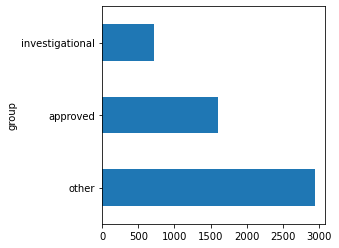

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
proteins_f.groupby('drugbank_id').first().value_counts('group').plot(kind='barh', ax=ax)
attila_utils.savefig(fig, 'drugbank-group-stats')

In [8]:
%connect_info

{
  "shell_port": 55947,
  "iopub_port": 55948,
  "stdin_port": 55949,
  "control_port": 55951,
  "hb_port": 55950,
  "ip": "127.0.0.1",
  "key": "057f1b9c-91e65bb627bf23ec94266765",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-3a1d13fa-bf79-424c-80de-2a43a54e0949.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
